In [2]:
%load_ext autoreload


In [3]:
%autoreload 2

In [148]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show
from scipy import stats
#%pylab inline

In [218]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-08-05/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 1869
files_end = 1955


In [230]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["112", "114", "115", "116", "117", "118", "119", "122", "124"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["112", "114", "115", "116", "117", "118", "119", "122", "124"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120']


In [220]:
columns_1 = ["cycle", "sample", "date","H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    
    if sample_name == "blank sol":
        blk_ls.append(sample)
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2015-08-05 13:10:00,1,SPEX 100ppb,3.171746,2.476720,17.008907,4.423246,12.316589,3.851003,7.206431,1.653199e-01,...,0.000377,0.000132,3.274635,0.001091,2.557345,0.001373,17.559210,4.565195,12.712983,3.974892
2015-08-05 13:10:00,2,SPEX 100ppb,3.344196,2.610962,17.927743,4.661875,12.979682,4.058179,7.593161,1.742102e-01,...,0.000228,0.000126,3.335951,0.000986,2.604720,0.001211,17.888118,4.651166,12.949868,4.049307
2015-08-05 13:10:00,3,SPEX 100ppb,3.270273,2.553675,17.537101,4.560467,12.698428,3.970518,7.429653,1.704179e-01,...,0.000223,0.000111,3.244772,0.000912,2.533750,0.001136,17.400902,4.524445,12.598576,3.939234
2015-08-05 13:10:00,4,SPEX 100ppb,3.141758,2.453438,16.847901,4.381273,12.199596,3.814619,7.137688,1.637289e-01,...,0.000185,0.000105,3.230450,0.000925,2.522301,0.001114,17.319751,4.503175,12.538954,3.920149
2015-08-05 13:10:00,5,SPEX 100ppb,3.353727,2.618442,17.978865,4.674929,13.016606,4.069529,7.614534,1.746539e-01,...,0.000201,0.000104,3.346840,0.000892,2.613220,0.001102,17.944991,4.665562,12.991482,4.061818
2015-08-05 13:10:00,6,SPEX 100ppb,3.366843,2.628620,18.049680,4.693497,13.068178,4.085766,7.644842,1.754042e-01,...,0.000183,0.000100,3.409669,0.000980,2.662283,0.001199,18.280056,4.752440,13.234292,4.137437
2015-08-05 13:10:00,7,SPEX 100ppb,3.387290,2.644686,18.159632,4.722083,13.147647,4.110731,7.691769,1.764352e-01,...,0.000198,0.000120,3.414853,0.001038,2.666688,0.001260,18.309630,4.760352,13.255823,4.144153
2015-08-05 13:10:00,8,SPEX 100ppb,3.394781,2.650359,18.198326,4.732320,13.175741,4.119485,7.707669,1.768161e-01,...,0.000222,0.000121,3.387361,0.000965,2.644681,0.001169,18.159876,4.721836,13.145913,4.110412
2015-08-05 13:10:00,9,SPEX 100ppb,3.387240,2.644314,18.154389,4.720882,13.142420,4.108685,7.687756,1.764332e-01,...,0.000185,0.000120,3.406590,0.001078,2.659788,0.001302,18.263206,4.748600,13.221735,4.133821


In [221]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    
    if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
        blk1 = sample-1
        blk2 = sample+1
        blk_corr_sample = True
    else:
        blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = data_sample_raw[np.abs(data_sample_raw-data_sample_raw.mean())<=(2*data_sample_raw.std())]
    
    data_sample = new_corr.internal_norm_2(denom_isotope, 10)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = data_sample[np.abs(data_sample-data_sample.mean())<=(2*data_sample.std())]
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

In [222]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)
df_internal_sub
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

,cycle,sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,112,114,115,116,117,118,119,120,122,124
date,,,,,,,,,,,,,,,,,,,,,
2015-08-05 13:10:00,1,SPEX 100ppb,0.029838,0.020199,0.010367,0.446,0.235258,0.742799,0.263368,0.142009,...,0.457637,0.318448,0.165320,7.206431,3.851003,12.316589,4.423246,17.008907,2.476720,3.171746
2015-08-05 13:10:00,2,SPEX 100ppb,0.029839,NaN,0.010368,0.446,0.235265,0.742788,0.263370,0.142011,...,0.481673,0.335098,0.174210,7.593161,4.058179,12.979682,4.661875,17.927743,2.610962,3.344196
2015-08-05 13:10:00,3,SPEX 100ppb,0.029835,0.020198,0.010365,0.446,0.235265,0.742784,0.263364,0.142007,...,0.471383,0.327842,0.170418,7.429653,3.970518,12.698428,4.560467,17.537101,2.553675,3.270273
2015-08-05 13:10:00,4,SPEX 100ppb,0.029836,0.020199,0.010366,0.446,0.235273,0.742796,0.263365,0.142015,...,0.452851,0.314947,0.163729,7.137688,3.814619,12.199596,4.381273,16.847901,2.453438,3.141758
2015-08-05 13:10:00,5,SPEX 100ppb,0.029838,0.020200,0.010366,0.446,0.235259,0.742798,0.263360,0.142011,...,0.483038,0.336029,0.174654,7.614534,4.069529,13.016606,4.674929,17.978865,2.618442,3.353727
2015-08-05 13:10:00,6,SPEX 100ppb,0.029840,0.020196,0.010369,0.446,0.235263,0.742799,0.263365,0.142006,...,0.484995,0.337274,0.175404,7.644842,4.085766,13.068178,4.693497,18.049680,2.628620,3.366843
2015-08-05 13:10:00,7,SPEX 100ppb,0.029839,0.020199,0.010366,0.446,0.235259,0.742774,0.263362,0.142012,...,0.487942,0.339359,0.176435,7.691769,4.110731,13.147647,4.722083,18.159632,2.644686,3.387290
2015-08-05 13:10:00,8,SPEX 100ppb,0.029840,0.020198,0.010367,0.446,0.235270,0.742802,0.263376,0.142010,...,0.488961,0.340067,0.176816,7.707669,4.119485,13.175741,4.732320,18.198326,2.650359,3.394781
2015-08-05 13:10:00,9,SPEX 100ppb,0.029841,0.020198,0.010372,0.446,0.235251,0.742779,NaN,0.142017,...,0.487604,0.339141,0.176433,7.687756,4.108685,13.142420,4.720882,18.154389,2.644314,3.387240


In [227]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SE])
df_internal_norm_mean["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["118/120"]

,mean,SE
date,,
2015-08-05 13:10:00,0.742788,5.321146e-07
2015-08-05 13:22:00,0.742789,5.890683e-07
2015-08-05 13:34:00,0.742785,6.364329e-07
2015-08-05 13:47:00,0.742779,8.156629e-07
2015-08-05 13:59:00,0.742775,5.003222e-07
2015-08-05 14:11:00,0.742779,6.020271e-07
2015-08-05 14:24:00,0.742775,5.518630e-07
2015-08-05 14:36:00,0.742770,5.905758e-07
2015-08-05 14:48:00,0.742770,5.962537e-07


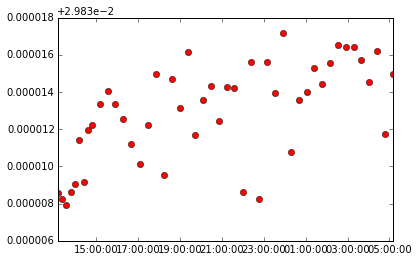

In [226]:
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] != "blank sol"]
plot_Nist = df_internal_norm_mean[(df_internal_norm_mean["118"] >= 2)]
dataplot = plot(plot_Nist.index, plot_Nist["112/120"], "ro")
show(dataplot)

In [246]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "SPEX 100ppb")].index
corr_values = df_external_norm_mean[(df_external_norm_mean["118/120"] >= 0.74289)]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
std_mean = corr_values[(corr_values["sample"] == "SPEX 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
#epsilon =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon["sample"] = sample

#epsilon = epsilon[new.index.isin(sub_index)]
#new[new.sample != "NIST 100ppb"]
epsilon

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,112,114,115,116,117,118,119,120,122,124,sample
date,,,,,,,,,,,,,,,,,,,,
2015-08-05 15:11:00,0.132345,1.797277,-0.250724,2.220446e-12,-0.039291,0.105886,0.278440,-0.224393,-0.798629,1211.999395,1198.492762,1189.562950,1182.461588,1175.118049,1168.046090,1161.062507,1153.692367,1139.509348,1125.170228,SPEX 100ppb
2015-08-05 15:33:00,0.096762,0.656682,-0.504872,2.220446e-12,0.057612,0.174173,0.186556,-0.335184,-0.965379,1130.956148,1117.363865,1110.835171,1104.715873,1098.113642,1091.693439,1085.151150,1078.556060,1065.457459,1052.309380,SPEX 100ppb
2015-08-05 15:55:00,-0.521491,-0.357388,-7.694195,2.220446e-12,0.053362,0.046629,0.153973,-0.243671,-0.443342,1170.148048,1156.232391,1142.269302,1144.199093,1137.698267,1131.224451,1124.834624,1118.315336,1105.490653,1092.852790,NIST 100ppb
2015-08-05 16:18:00,-1.309000,-2.115261,-0.515173,2.220446e-12,0.193957,0.144324,0.102096,-0.194165,-0.720182,1006.344650,996.108161,990.880318,986.325125,981.640107,976.684610,971.798498,966.913660,957.224752,947.348838,SPEX 100ppb
2015-08-05 16:41:00,-0.939506,-1.114817,-7.138210,2.220446e-12,0.233663,0.129753,0.152434,-0.270786,-0.856035,2786.038071,2780.006507,2752.336835,2755.664429,2750.017779,2744.205756,2738.551883,2732.861479,2721.533070,2709.980324,Cd-Sn-Std 1
2015-08-05 17:04:00,-1.740556,-2.268662,1.048690,2.220446e-12,0.068835,0.083002,0.072546,-0.337299,-0.732318,802.276044,793.613133,790.439481,785.218640,780.886711,776.569078,772.227069,767.895815,759.083743,750.385276,SPEX 100ppb
2015-08-05 17:28:00,-1.142051,-1.047187,-7.314272,2.220446e-12,0.110340,0.119367,0.212479,-0.293061,-0.551634,1416.997949,1408.435348,1396.151994,1400.163167,1395.980620,1391.699696,1387.602492,1383.197821,1374.646414,1366.161958,SPEX1 Ag1x8_5
2015-08-05 17:50:00,-0.099569,0.190630,0.298680,2.220446e-12,0.025417,-0.019385,-0.028642,-0.165817,-0.601359,643.008869,636.388416,633.983864,630.508897,627.255639,624.048799,620.891508,617.693542,611.285590,604.732060,SPEX 100ppb
2015-08-05 18:13:00,-1.407735,-1.172985,-8.306241,2.220446e-12,0.086419,0.056134,0.112645,-0.152500,-0.596516,2296.427887,2292.989364,2276.842476,2284.027364,2281.255609,2278.445147,2275.768555,2272.908745,2267.808755,2262.298309,SPEX1 TRU_6 U


In [247]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

epsilon = epsilon.drop(["112", "114", "115", "116", "117", "118", "119", "120", "122", "124"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, np.size]), decimals=2)
epsilon_sum

112/120            114/120            115/120        \
                            mean   SD2 size    mean   SD2 size    mean   SD2   
sample                                                                         
BHVO-2 1_1(2)              -0.76  0.00    1   -1.48  0.00    1   -6.37  0.00   
BHVO-2 1_2(2)               0.24  0.00    1    1.22  0.00    1   -7.56  0.00   
BHVO-2 2_1                 -0.09  0.00    1   -0.72  0.00    1   -8.48  0.00   
Cd-Sn-Std 1                -0.94  0.00    1   -1.11  0.00    1   -7.14  0.00   
NIST 100ppb                -0.52  0.00    1   -0.36  0.00    1   -7.69  0.00   
SPEX 100ppb                 0.00  1.46   22    0.00  2.17   22   -0.00  1.52   
SPEX 100ppb + 0.005ppb U    0.16  0.07    2    0.41  1.45    2   -0.35  0.47   
SPEX 100ppb + 0.05ppb U     0.86  0.36    2    0.71  1.64    2    0.69  0.98   
SPEX1 1_1(1)               -0.07  0.00    1   -0.36  0.00    1   -7.85  0.00   
SPEX1 Ag1x8_5              -1.14  0.00    1   -1.05  0.00    1   -7.31  0.00   
SPEX1 TRU_6 U              -1.41  0.00    1   -1.17  0.00    1   -8.31  0.00   
SPEX1-II 3_1                0.06  0.00    1   -0.23  0.00    1   -7.89  0.00   
SPEX1-II 4_1               -0.14  0.00    1   -0.31  0.00    1   -7.14  0.00   
ZH09-05 10.3_1(1)          -0.65  0.00    1   -0.92  0.00    1   -8.34  0.00   
ZH09-05 23.3_1(1)          -0.25  0.00    1    1.11  0.00    1   -7.97  0.00   

                              116/120 ...  118/120 119/120            122/120  \
                         size    mean ...     size    mean   SD2 size    mean   
sample                                ...                                       
BHVO-2 1_1(2)               1       0 ...        1   -0.04  0.00    1   -0.40   
BHVO-2 1_2(2)               1       0 ...        1   -0.08  0.00    1   -0.21   
BHVO-2 2_1                  1       0 ...        1   -0.08  0.00    1   -0.29   
Cd-Sn-Std 1                 1       0 ...        1    0.15  0.00    1   -0.27   
NIST 100ppb                 1       0 ...        1    0.15  0.00    1   -0.24   
SPEX 100ppb                22       0 ...       22   -0.00  0.19   22   -0.00   
SPEX 100ppb + 0.005ppb U    2       0 ...        2    0.15  0.01    2    0.01   
SPEX 100ppb + 0.05ppb U     2       0 ...        2    0.85  0.21    2    0.17   
SPEX1 1_1(1)                1       0 ...        1    0.11  0.00    1    0.19   
SPEX1 Ag1x8_5               1       0 ...        1    0.21  0.00    1   -0.29   
SPEX1 TRU_6 U               1       0 ...        1    0.11  0.00    1   -0.15   
SPEX1-II 3_1                1       0 ...        1    0.05  0.00    1   -0.23   
SPEX1-II 4_1                1       0 ...        1   -0.06  0.00    1   -0.25   
ZH09-05 10.3_1(1)           1       0 ...        1   -0.04  0.00    1   -0.09   
ZH09-05 23.3_1(1)           1       0 ...        1    0.05  0.00    1    0.10   

                                    124/120             
                           SD2 size    mean   SD2 size  
sample                                                  
BHVO-2 1_1(2)             0.00    1   -0.43  0.00    1  
BHVO-2 1_2(2)             0.00    1   -0.41  0.00    1  
BHVO-2 2_1                0.00    1   -0.35  0.00    1  
Cd-Sn-Std 1               0.00    1   -0.86  0.00    1  
NIST 100ppb               0.00    1   -0.44  0.00    1  
SPEX 100ppb               0.46   22   -0.00  1.15   22  
SPEX 100ppb + 0.005ppb U  0.18    2    0.26  0.06    2  
SPEX 100ppb + 0.05ppb U   0.11    2    0.46  0.15    2  
SPEX1 1_1(1)              0.00    1    0.09  0.00    1  
SPEX1 Ag1x8_5             0.00    1   -0.55  0.00    1  
SPEX1 TRU_6 U             0.00    1   -0.60  0.00    1  
SPEX1-II 3_1              0.00    1   -0.41  0.00    1  
SPEX1-II 4_1              0.00    1   -0.25  0.00    1  
ZH09-05 10.3_1(1)         0.00    1   -0.03  0.00    1  
ZH09-05 23.3_1(1)         0.00    1    0.16  0.00    1  

[15 rows x 27 columns]

([<matplotlib.axis.XTick at 0x1103b44d0>,
 <a list of 15 Text xticklabel objects>)

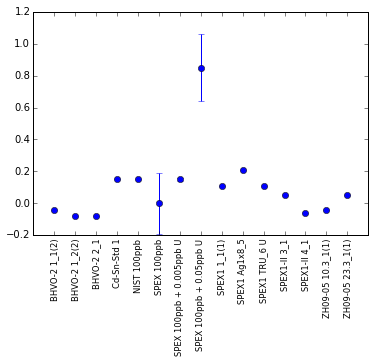

In [260]:
x = range(1, len(epsilon_sum.index)+1)
plot(errorbar(x, epsilon_sum["119/120"]["mean"], yerr = epsilon_sum["119/120"]["SD2"], ls='none', marker="o")
xticks(x, epsilon_sum.index, size='small', rotation=90)

([<matplotlib.axis.XTick at 0x1126302d0>,
 <a list of 38 Text xticklabel objects>)

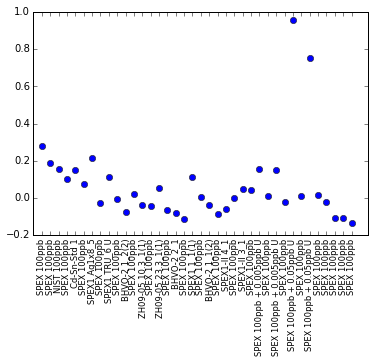

In [268]:
x = range(1, len(epsilon["sample"])+1)
plot(x, epsilon["119/120"], marker="o", ls="none")
xticks(x, epsilon["sample"], size='small', rotation=90)

In [214]:
df_all.to_csv(path_sav + "Sn_H8_L4_2_cycles_NU_Signals_zero_corr.csv", mode='a', header=False)

In [215]:
df_internal_sub.to_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm.csv", mode='a', header=False)

In [229]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_no_bgd_corr.csv")

In [228]:
epsilon.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_epsilon_no_bgd_corr.csv")